In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers, losses, metrics, datasets

import matplotlib.pyplot as plt

In [3]:
EPOCHS = 30
BATCH_SIZE = 128
ETA = 1e-3

In [4]:
trainset, testset = datasets.cifar10.load_data()

In [5]:
train_loader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
test_loader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

## Sparse AutoEncoder

In [6]:
class SparseAutoEncoder(models.Model):
    
    def __init__(self):
        super(SparseAutoEncoder, self).__init__()
        
        self.encoder = models.Sequential([
            layers.Conv2DTranspose(16, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
        ])
        
        self.decoder = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(16, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(16, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(3, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
        ])
        
    def call(self, x, training=False):
        latent = self.encoder(x)
        x_rec = self.decoder(latent)
        
        return x_rec, latent

In [7]:
def compute_sae_loss(x_orig, x_rec, latent):
    reconstruction_loss = tf.reduce_mean(tf.math.abs(x_orig - x_rec))
    sparse_loss = tf.reduce_mean(latent**2)
    
    loss = reconstruction_loss + 0.1*sparse_loss
    
    return loss

In [8]:
def plot(original, reconstructed):
    plt.figure(figsize=(4, 2))
    
    img1 = original.numpy()*256
    img1 = img1.astype(np.uint8)
    
    img2 = reconstructed.numpy()*256
    img2 = img2.astype(np.uint8)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Reconstructed")
    
    plt.show()

In [9]:
def train():
    model = SparseAutoEncoder()
    optimizer = optimizers.Adam(learning_rate=ETA)
    
    train_loss_metric = metrics.Mean()
    test_loss_metric = metrics.Mean()
    
    for e in range(EPOCHS):
        
        for x, y in train_loader:
            with tf.GradientTape() as tape:
                x = tf.cast(x, dtype=tf.float32)/256
                x_rec, latent = model(x)
                loss = compute_sae_loss(x, x_rec, latent)
                
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss_metric.update_state(loss)
            
        for x, y in test_loader:
            x = tf.cast(x, dtype=tf.float32)/256
            x_rec, latent = model(x)
            loss = compute_sae_loss(x, x_rec, latent)
            
            test_loss_metric.update_state(loss)
            
        print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_loss_metric.result():.6f}, test loss: {test_loss_metric.result():.6f}")
        index = np.random.randint(tf.shape(x)[0])
        plot(x[index], x_rec[index])
        
        train_loss_metric.reset_states()
        test_loss_metric.reset_states()

Epochs 1/30, train loss: 0.053112, test loss: 0.024967


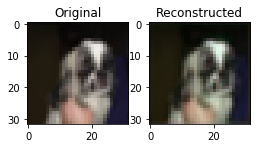

Epochs 2/30, train loss: 0.018385, test loss: 0.018756


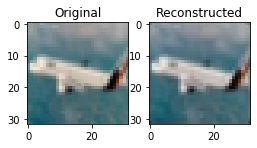

Epochs 3/30, train loss: 0.015320, test loss: 0.014442


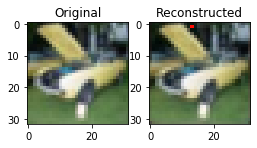

Epochs 4/30, train loss: 0.014221, test loss: 0.010364


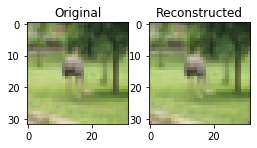

Epochs 5/30, train loss: 0.011447, test loss: 0.010896


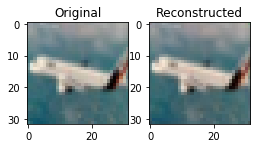

Epochs 6/30, train loss: 0.011196, test loss: 0.016382


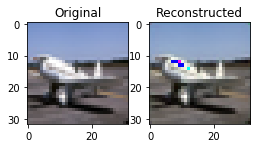

Epochs 7/30, train loss: 0.014688, test loss: 0.013847


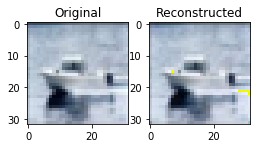

Epochs 8/30, train loss: 0.011602, test loss: 0.010745


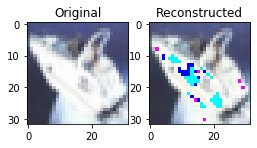

Epochs 9/30, train loss: 0.008737, test loss: 0.008016


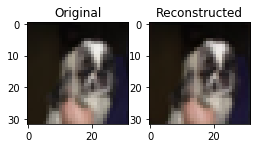

Epochs 10/30, train loss: 0.011615, test loss: 0.007454


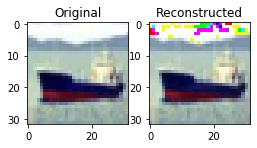

Epochs 11/30, train loss: 0.007784, test loss: 0.007614


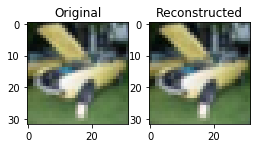

Epochs 12/30, train loss: 0.012056, test loss: 0.009883


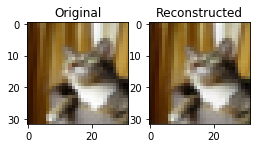

Epochs 13/30, train loss: 0.010720, test loss: 0.008431


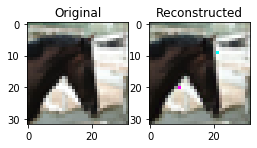

Epochs 14/30, train loss: 0.007088, test loss: 0.006472


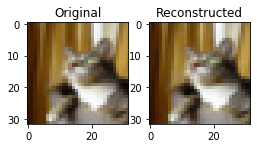

Epochs 15/30, train loss: 0.007943, test loss: 0.010578


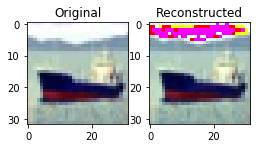

Epochs 16/30, train loss: 0.010381, test loss: 0.009760


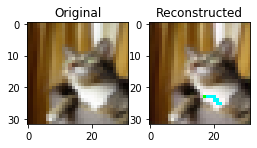

Epochs 17/30, train loss: 0.010459, test loss: 0.008361


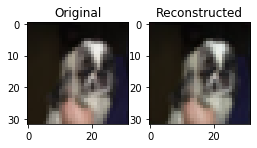

Epochs 18/30, train loss: 0.009280, test loss: 0.009663


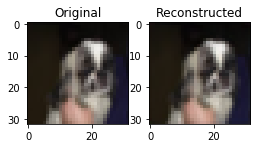

Epochs 19/30, train loss: 0.008030, test loss: 0.007801


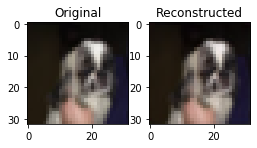

Epochs 20/30, train loss: 0.008417, test loss: 0.008861


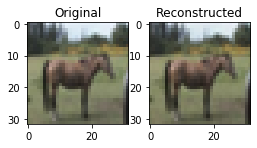

Epochs 21/30, train loss: 0.008441, test loss: 0.007048


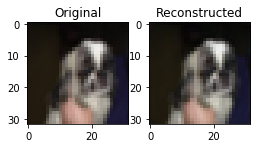

Epochs 22/30, train loss: 0.008963, test loss: 0.006899


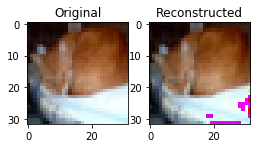

Epochs 23/30, train loss: 0.009019, test loss: 0.007992


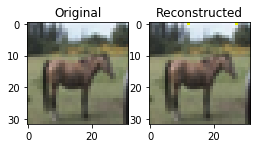

Epochs 24/30, train loss: 0.006694, test loss: 0.005670


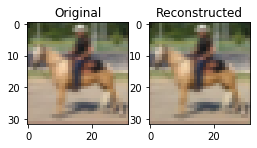

Epochs 25/30, train loss: 0.007349, test loss: 0.005751


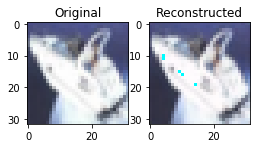

Epochs 26/30, train loss: 0.007563, test loss: 0.010125


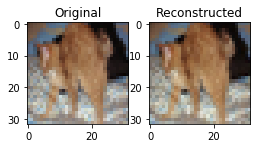

Epochs 27/30, train loss: 0.008814, test loss: 0.009147


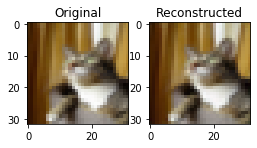

Epochs 28/30, train loss: 0.006582, test loss: 0.007083


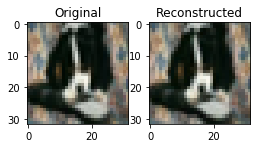

Epochs 29/30, train loss: 0.007926, test loss: 0.009456


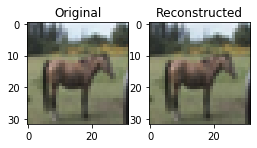

Epochs 30/30, train loss: 0.006932, test loss: 0.004735


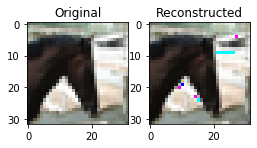

In [10]:
train()

## Denoising AutoEncoder

In [11]:
class AutoEncoder(models.Model):
    """
    오토인코더
    """
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
        ])
        
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x, training=False):
        latent = self.encoder(x, training=training)
        x_rec = self.decoder(latent, training=training)
        
        return x_rec

In [12]:
def add_noise(x):
    x_with_noise = x + tf.random.normal(tf.shape(x))*0.01
    return x_with_noise

In [13]:
def compute_loss(x1, x2):
    reconstruction_loss = tf.reduce_mean(tf.math.abs(x1 - x2))
    return reconstruction_loss

In [21]:
def train():
    model = AutoEncoder()
    optimizer = optimizers.Adam(learning_rate=ETA)
    
    train_loss_metric = metrics.Mean()
    test_loss_metric = metrics.Mean()
    
    for e in range(EPOCHS):
        
        for x, y in train_loader:
            with tf.GradientTape() as tape:
                x = tf.cast(x, dtype=tf.float32)/256
                x_with_noise = add_noise(x)
                x_rec = model(x_with_noise)
                loss = compute_loss(x, x_rec)
                
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss_metric.update_state(loss)
            
        for x, y in test_loader:
            x = tf.cast(x, dtype=tf.float32)/256
            x_rec = model(x)
            loss = compute_loss(x, x_rec)
            
            test_loss_metric.update_state(loss)
            
        print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_loss_metric.result():.6f}, test loss: {test_loss_metric.result():.6f}")
        index = np.random.randint(tf.shape(x)[0])
        plot(x[index], x_rec[index])
        
        train_loss_metric.reset_states()
        test_loss_metric.reset_states()

Epochs 1/30, train loss: 0.071296, test loss: 0.046439


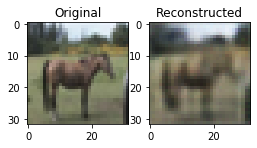

Epochs 2/30, train loss: 0.040458, test loss: 0.037399


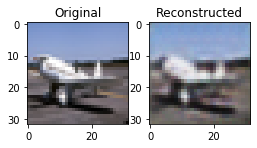

Epochs 3/30, train loss: 0.033591, test loss: 0.032072


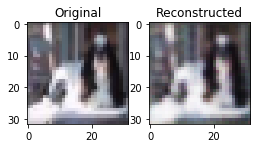

Epochs 4/30, train loss: 0.029952, test loss: 0.030120


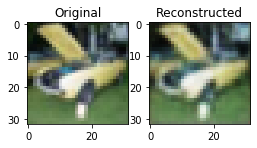

Epochs 5/30, train loss: 0.027586, test loss: 0.025240


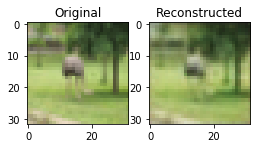

Epochs 6/30, train loss: 0.025834, test loss: 0.024184


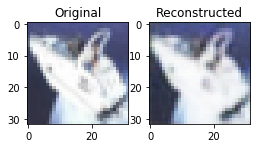

Epochs 7/30, train loss: 0.024484, test loss: 0.022613


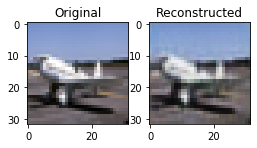

Epochs 8/30, train loss: 0.023449, test loss: 0.022122


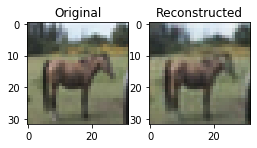

Epochs 9/30, train loss: 0.022530, test loss: 0.020893


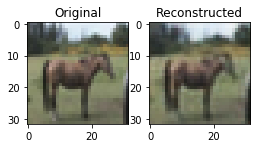

Epochs 10/30, train loss: 0.021740, test loss: 0.020561


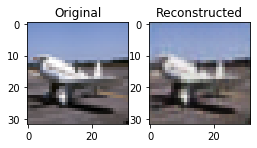

Epochs 11/30, train loss: 0.021036, test loss: 0.021977


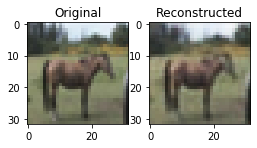

Epochs 12/30, train loss: 0.020442, test loss: 0.018716


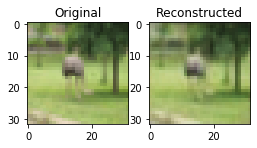

Epochs 13/30, train loss: 0.019869, test loss: 0.020108


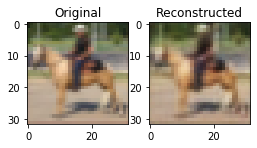

Epochs 14/30, train loss: 0.019344, test loss: 0.017659


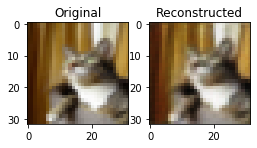

Epochs 15/30, train loss: 0.018947, test loss: 0.018831


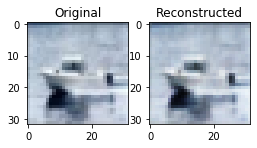

Epochs 16/30, train loss: 0.018494, test loss: 0.017943


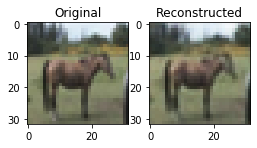

Epochs 17/30, train loss: 0.018157, test loss: 0.016957


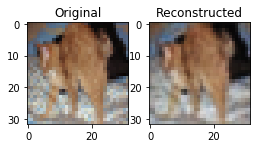

Epochs 18/30, train loss: 0.017802, test loss: 0.017296


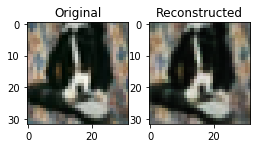

Epochs 19/30, train loss: 0.017565, test loss: 0.019394


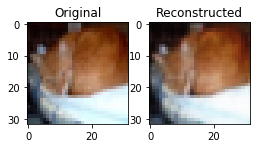

Epochs 20/30, train loss: 0.017286, test loss: 0.015832


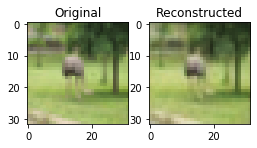

Epochs 21/30, train loss: 0.017004, test loss: 0.017145


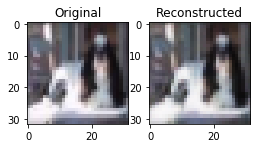

Epochs 22/30, train loss: 0.016782, test loss: 0.016684


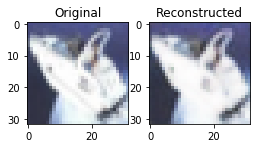

Epochs 23/30, train loss: 0.016595, test loss: 0.017223


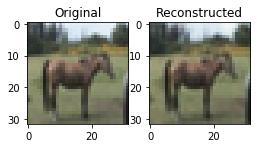

Epochs 24/30, train loss: 0.016395, test loss: 0.018857


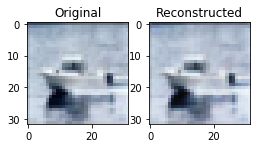

Epochs 25/30, train loss: 0.016216, test loss: 0.016755


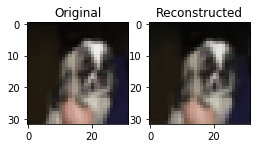

Epochs 26/30, train loss: 0.016021, test loss: 0.014519


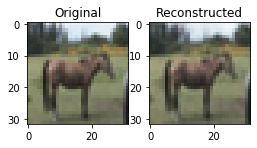

Epochs 27/30, train loss: 0.015901, test loss: 0.015601


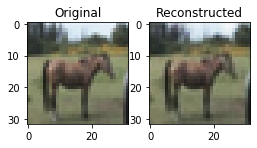

Epochs 28/30, train loss: 0.015693, test loss: 0.014826


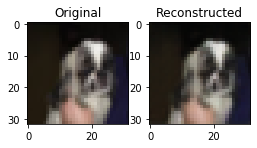

Epochs 29/30, train loss: 0.015612, test loss: 0.016667


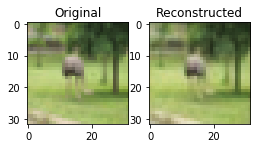

Epochs 30/30, train loss: 0.015440, test loss: 0.014337


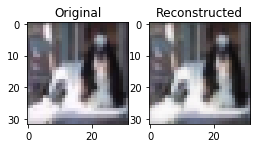

In [22]:
train()